In [20]:
import glob
from importlib import reload
import os
import sys
sys.path.append('..')

import cartopy.crs as ccrs
import cartopy.feature as cfeature 
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import metpy  
import numpy as np
import seaborn as sb
import xarray as xr

from src import processing as pr
reload(pr)

<module 'src.processing' from '/Users/geet/Documents/Repositories/Owned/goesdata/notebooks/../src/processing.py'>

In [141]:
file = "/Users/geet/Documents/Repositories/Owned/goesdata/Data/goes16/2023/06/07/ABI-L1b-RadF/13/C13/OR_ABI-L1b-RadF-M6C13_G16_s20231581330215_e20231581339535_c20231581339577.nc"

In [142]:
img = pr.Image(file)
extent = (-150,5,-18.5,18.5)

ds = img.subset_region_from_latlon_extents(extent, unit="degree")

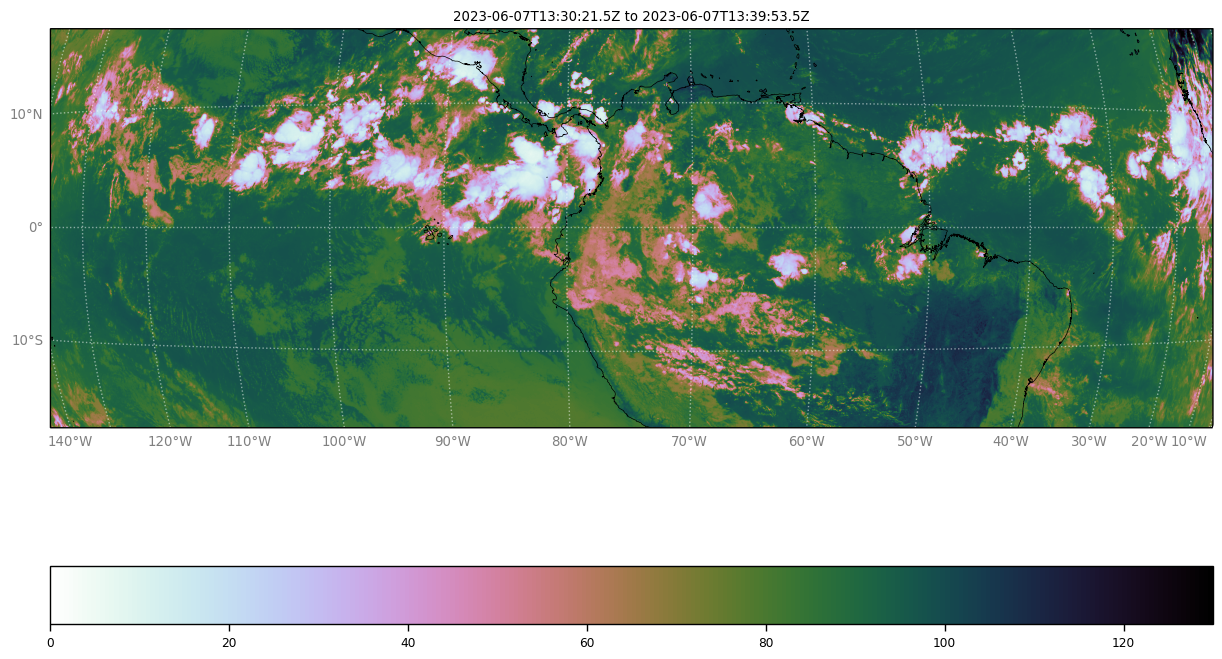

In [145]:
data = ds.metpy.parse_cf('Rad')
geostationary = data.metpy.cartopy_crs

# Sweep the ABI data from the x (north/south) and y (east/west) axes
x = data.x
y = data.y

# Use the geostationary projection to plot the image on a map
# This method streches the image across a map with the same projection and dimensions as the data
sb.set_context('paper')
fig = plt.figure(figsize=(15, 12))

# Create axis with Geostationary projection
ax = fig.add_subplot(1, 1, 1, projection=geostationary)

# Add the RGB True Color image to the figure. The data is in the same projection as the axis created
im = ax.imshow(ds.Rad, origin='upper',
          extent=(x.min(), x.max(), y.min(), y.max()), transform=geostationary,cmap='cubehelix_r',vmin=0,vmax=130)
# ax.set_extent(extent, crs=ccrs.PlateCarree())
# Add coastlines and states
ax.coastlines(resolution='10m', color='black', linewidth=.5)

#Add title
plt.title(f"{ds.attrs['time_coverage_start']} to {ds.attrs['time_coverage_end']}")
plt.colorbar(im,orientation='horizontal')

# # # Draw grid.
gl = ax.gridlines(ccrs.PlateCarree(), linewidth = 1, color = 'w', alpha = 0.5, linestyle=':', draw_labels = True)
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.ylines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 10))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 10))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'color': 'grey'}
gl.ylabel_style = {'color': 'grey'}

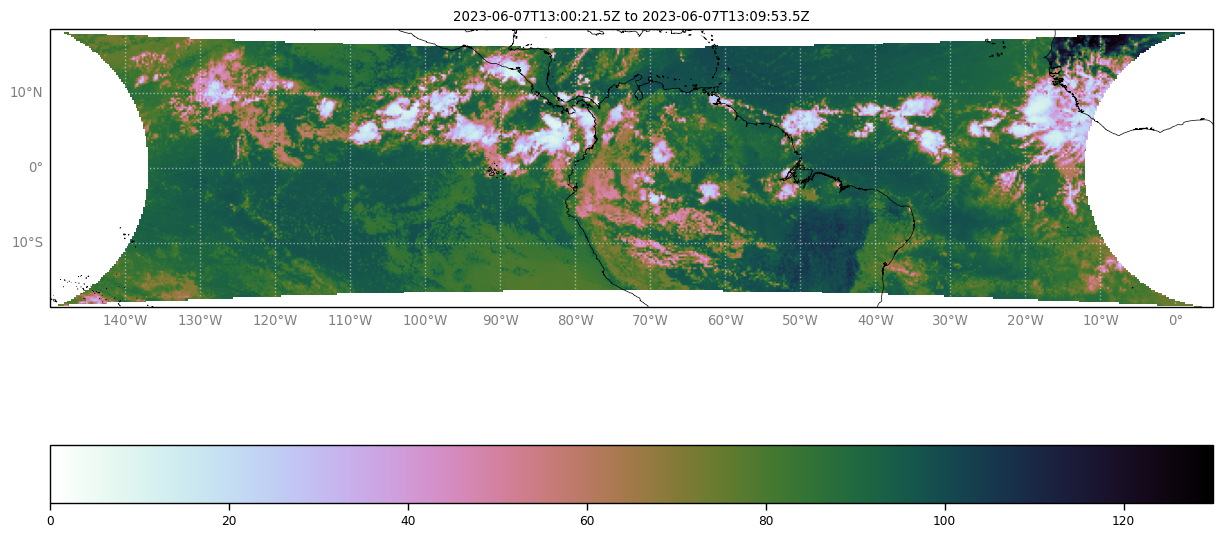

In [140]:
data = ds.metpy.parse_cf('Rad')
geostationary = data.metpy.cartopy_crs

# Sweep the ABI data from the x (north/south) and y (east/west) axes
x = data.x
y = data.y

# Use the geostationary projection to plot the image on a map
# This method streches the image across a map with the same projection and dimensions as the data
sb.set_context('paper')
fig = plt.figure(figsize=(15, 12))

# Create axis with Geostationary projection
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Add the RGB True Color image to the figure. The data is in the same projection as the axis created
im = ax.imshow(ds.Rad, origin='upper',
          extent=(x.min(), x.max(), y.min(), y.max()), transform=geostationary,cmap='cubehelix_r',vmin=0,vmax=130)
ax.set_extent(extent, crs=ccrs.PlateCarree())
# Add coastlines and states
ax.coastlines(resolution='10m', color='black', linewidth=.5)

#Add title
plt.title(f"{ds.attrs['time_coverage_start']} to {ds.attrs['time_coverage_end']}")
plt.colorbar(im,orientation='horizontal')

# # # Draw grid.
gl = ax.gridlines(ccrs.PlateCarree(), linewidth = 1, color = 'w', alpha = 0.5, linestyle=':', draw_labels = True)
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.ylines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 10))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 10))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'color': 'grey'}
gl.ylabel_style = {'color': 'grey'}

In [187]:
"/Users/geet/Documents/Repositories/Owned/goesdata/Data/goes16/2023/06/08/ABI-L2-CMIPF/16/C01/OR_ABI-L2-CMIPF-M6C01_G16_s20231591600217_e20231591609525_c20231591609594.nc"

data_dir = "/Users/geet/Documents/Repositories/Owned/goesdata/Data/goes16/2023/06/08/ABI-L2-CMIPF/16"
filename_prefix = "OR_ABI-L2-CMIPF-M6"
filename_suffix = "_G16_s20231591600217"
channels = ["C01","C02","C03","C13"]
file = {}; ds = {}
for channel in channels:
    complete_filepath = glob.glob(os.path.join(data_dir,channel,filename_prefix+channel+filename_suffix+"*.nc"))
    if len(complete_filepath) > 1:
        print("More than one file found. Check what's going on.")
    else:
        file[channel] = complete_filepath[0]
        ds[channel] = xr.open_dataset(file[channel])

In [188]:
R = ds['C02']['CMI']
G = ds['C03']['CMI']
B = ds['C01']['CMI']

# kappa_R = ds['C02']['kappa0']
# kappa_G = ds['C03']['kappa0']
# kappa_B = ds['C01']['kappa0']

#To convert radiance to reflectance, use formula:
#reflectance (ρf(υ)) = kappa factor(κ) * radiance (L(ν))
#Source: GOES-R Series Product Definition and User Guide (PUG) Volume 3, Revision 2.2, pages 27-28
# R_ref = kappa_R * R
# G_ref = kappa_G * G  
# B_ref = kappa_B * B 

In [189]:
# Apply range limits for each channel. Reflectance values must be between 0 and 1.
R_ref = np.clip(R, 0, 1)
G_ref = np.clip(G, 0, 1)
B_ref = np.clip(B, 0, 1)

In [190]:
# Apply a gamma correction to the image to correct ABI detector brightness
gamma = 2.2
R = np.power(R_ref, 1/gamma)
G = np.power(G_ref, 1/gamma)
B = np.power(B_ref, 1/gamma)

In [195]:
# Define the rebin function that will be used to resample the band resolution
# Rebin function from https://stackoverflow.com/questions/8090229/resize-with-averaging-or-rebin-a-numpy-2d-array
def rebin(a, shape):
    sh = shape[0],a.shape[0]//shape[0],shape[1],a.shape[1]//shape[1]
    return a.reshape(sh).mean(-1).mean(1)

In [205]:
#Resample the Red Band resolution
R_values = R.values
G_values = G.values
B_values = B.values
# R_rescaled = rebin(R_values,[10848,10848])
R_rescaled = rebin(R_values,[5424,5424])
G_rescaled = rebin(G_values,[5424,5424])
B_rescaled = rebin(B_values,[5424,5424])

In [206]:
# GOES-R Series satellites do not have a channel in the visible green range. Band 3 is a NIR channel typically used to monitor vegetation.
# Calculate the "True" Green Band to serve as a green proxy for the RGB True Color image, using a fractional combination.
# Source: "Generation of GOES‐16 True Color Imagery without a Green Band" - https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2018EA000379
G_true = 0.45*R_rescaled + 0.1*G_rescaled + 0.45*B_rescaled
G_true = np.clip(G_true, 0, 1)  # Apply band limits again, just in case.

RGB = np.dstack([R_rescaled, G_true, B_rescaled])

In [212]:
# ds['C13'] = xr.open_dataset('/Users/geet/Documents/Repositories/Owned/goesdata/Data/goes16/2023/06/05/ABI-L2-CMIPF/14/C13/OR_ABI-L2-CMIPF-M6C13_G16_s20231561400213_e20231561409533_c20231561410000.nc')
cleanIR = ds['C13']['CMI']
cleanIR = (cleanIR-90)/(313-90)

# Apply range limits to make sure values are between 0 and 1
cleanIR = np.clip(cleanIR, 0, 1)

# Invert colors so that cold clouds are white
cleanIR = 1 - cleanIR

# Lessen the brightness of the coldest clouds so they don't appear so bright
# when we overlay it on the true color image.
cleanIR = cleanIR/1.4

# Yes, we still need 3 channels as RGB values. This will be a grey image.
RGB_cleanIR = np.dstack([cleanIR, cleanIR, cleanIR])

# Maximize the RGB values between the True Color Image and Clean IR image
RGB_ColorIR = np.dstack([np.maximum(R_rescaled, cleanIR), np.maximum(G_true, cleanIR),
                         np.maximum(B_rescaled, cleanIR)])

/Users/geet/Documents/Repositories/Owned/goesdata/goesdata_env/lib/python3.10/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


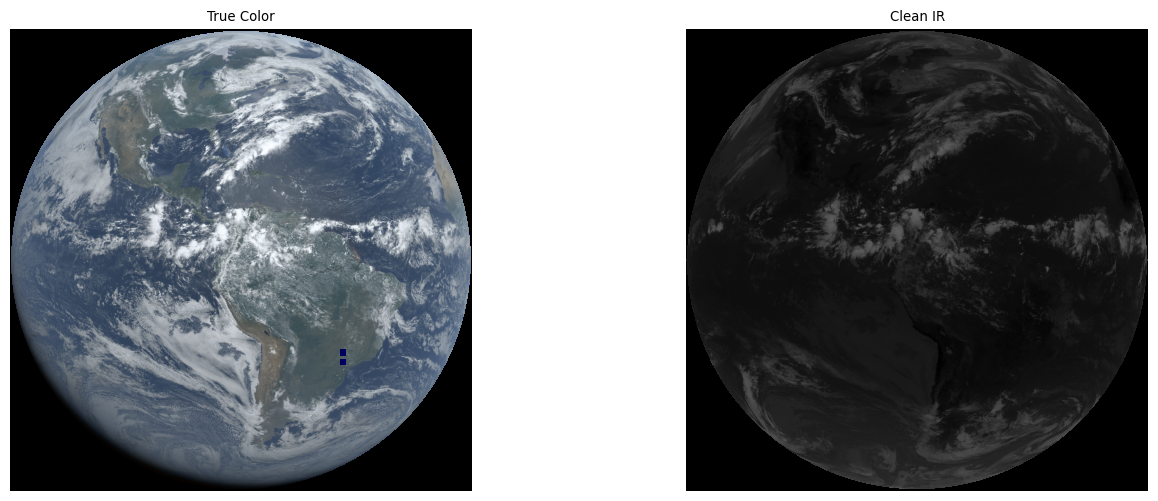

In [209]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.set_title('True Color')
ax1.imshow(RGB)
ax1.axis('off')

ax2.set_title('Clean IR')
ax2.imshow(RGB_cleanIR)
ax2.axis('off');

In [210]:
def contrast_correction(color, contrast):
    """
    Modify the contrast of an RGB
    See:
    https://www.dfstudios.co.uk/articles/programming/image-programming-algorithms/image-processing-algorithms-part-5-contrast-adjustment/

    Input:
        color    - an array representing the R, G, and/or B channel
        contrast - contrast correction level
    """
    F = (259*(contrast + 255))/(255.*259-contrast)
    COLOR = F*(color-.5)+.5
    COLOR = np.clip(COLOR, 0, 1)  # Force value limits 0 through 1.
    return COLOR

# Amount of contrast
contrast_amount = 105

# Apply contrast correction
RGB_contrast = contrast_correction(RGB, contrast_amount)

# Add in clean IR to the contrast-corrected True Color image
RGB_contrast_IR = np.dstack([np.maximum(RGB_contrast[:, :, 0], cleanIR),
                             np.maximum(RGB_contrast[:, :, 1], cleanIR),
                             np.maximum(RGB_contrast[:, :, 2], cleanIR)])

In [215]:
dat = ds['C13'].metpy.parse_cf('CMI')

geos = dat.metpy.cartopy_crs

# We also need the x (north/south) and y (east/west) axis sweep of the ABI data
x = dat.x
y = dat.y

fig = plt.figure(figsize=(15, 12))

ax1 = fig.add_subplot(1, 2, 1, projection=geos)
ax2 = fig.add_subplot(1, 2, 2, projection=geos)

ax1.imshow(RGB_ColorIR, origin='upper',
           extent=(x.min(), x.max(), y.min(), y.max()),
           transform=geos)
ax1.coastlines(resolution='50m', color='black', linewidth=.5)
# ax1.add_feature(ccrs.cartopy.feature.BORDERS)
ax1.set_title('True Color and Night IR')

ax2.imshow(RGB_contrast_IR, origin='upper',
           extent=(x.min(), x.max(), y.min(), y.max()),
           transform=geos)
ax2.coastlines(resolution='50m', color='black', linewidth=.5)
# ax2.add_feature(ccrs.cartopy.feature.BORDERS)
ax2.set_title('Contrast Correction = {}'.format(contrast_amount))

plt.subplots_adjust(wspace=.02)
plt.savefig('True color & Night IR - also with contrast increased.png',dpi=300)
plt.close()

/Users/geet/Documents/Repositories/Owned/goesdata/goesdata_env/lib/python3.10/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


In [22]:
data = ds['C01'].metpy.parse_cf('Rad')
geostationary = data.metpy.cartopy_crs

# Sweep the ABI data from the x (north/south) and y (east/west) axes
x = data.x
y = data.y

# Use the geostationary projection to plot the image on a map
# This method streches the image across a map with the same projection and dimensions as the data
fig = plt.figure(figsize=(15, 12))

# Create axis with Geostationary projection
ax = fig.add_subplot(1, 1, 1, projection=geostationary)

# Add the RGB True Color image to the figure. The data is in the same projection as the axis created
ax.imshow(RGB, origin='upper',
          extent=(x.min(), x.max(), y.min(), y.max()), transform=geostationary)

# Add coastlines and states
ax.coastlines(resolution='50m', color='black', linewidth=.5)

#Add title
plt.title('GOES-16 RGB True Color', fontsize=15)
plt.savefig(f'GOES-16 RGB True Color - {filename_prefix}{filename_suffix}.png',dpi=300)
plt.close()

/Users/geet/Documents/Repositories/Owned/goesdata/goesdata_env/lib/python3.10/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
